# [Introduction to Data Science](http://datascience-intro.github.io/1MS041-2023/)    
## 1MS041, 2023 
&copy;2023 Raazesh Sainudiin, Benny Avelin. [Attribution 4.0 International     (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)

# Training and Testing

## Topics

* Supervised Learning
* Probabilistic viewpoint of machine learning
* Logistic regression
* Measuring model performance
* Multiple class logistic regression

## The underlying problem

Consider the supervised learning problem. I.e. we have

1. A generator G
2. A supervisor S
3. A learning machine LM

The generator, gives $X$ from $F_X$ and the supervisor $S$ gives $Y$ from $F_{Y \mid X}$, the goal of the learning machine is to mimic the supervisor in some way.

We will look at this from the context of the Pattern Recognition problem i.e. $Y$ is binary.

What we have seen so far is that we start with the statistical model, i.e. that

$$
    \mathcal{F} = \{F(x,y) = H(y;p(x))F(x), p \in C([0,1],R)\}
$$

where $H(y;p)$ is the CDF of Bernoulli($p$).

Our model space is $\mathcal{M} = \{g_\lambda(x): g_\lambda(x) \in \{0,1\}\}$.

Let us consider that we have some loss function $L$ and consider the risk

$$
   R(\lambda) = \int L(y, g_\lambda(x)) dF(x,y) = \mathbb{E}[L(Y,g_\lambda(X)]
$$

As we have alluded to before, the learning machine LM does not have access to $F(x,y)$ directly, but only though observations (examples) that the supervisor S provides, and thus the only thing the LM can hope to do, is to approximate the risk using those observations. The natural candidate which we have seen before in chapter 6, is that we will use the empirical risk

$$
    \hat R_n(\lambda) = \frac{1}{n} \sum_{i=1}^n L(Y_i, g_\lambda(X_i))
$$

Recall this data that we used as an example for the perceptron

<img src="./images/blue_red_points.png"></a>

In this case, the perceptron algorithm produced a decision function $g_{\hat \lambda}$ that perfectly split the data into two parts, i.e.

$$
    \hat R_n(\hat \lambda) = 0
$$

> The main goal of learning is the one of generalization, i.e. that the decision function we found actually performs well on unseen data.

That is, we want the true risk to also be small, specifically we want

$$
    R(\hat \lambda) \text{ is small.}
$$

Again, this would involve computing an expecation and the LM does not have access to $F(x,y)$, and thus would need to compute the empirical counterpart. **But we have used up all our data!!**

> What can we do?

If we where smart we would have kept some data that we did not use to find $\hat \lambda$ and use that data to approximate $R(\hat \lambda)$. This is called the **train**-**test** methodology. Lets see how that would work

In [1]:
import numpy as np

def gen_data(n_points=5,sep=1):
    #定义一个函数gen_data，用于生成二类数据集，数据点的数量为5，两个类别之间的距离为1
    
    np.random.seed(3)
    #设置随机数生成器的种子为3，以确保每次运行代码时生成的随机数相同
    
    W = np.array([[1,-1],[1,1]])/np.sqrt(2)
    #创建一个权重矩阵W，用于生成类别之间的分离。
    
    rnd_pos_1 = np.random.uniform(0,1,size=(n_points,2))
    #生成一个大小为(n_points,2)的随机均匀分布数组，表示第一个类别的随机位置
    
    X1 = (rnd_pos_1 + np.array([-1-sep,0]))@W
    #将第一个类别的随机位置进行线性变换，以创建最终的数据点。这个变换包括平移和点积操作
    
    rnd_pos_2 = np.random.uniform(0,1,size=(n_points,2))
    #类似地，生成第二个类别的随机位置。
    
    X2 = (rnd_pos_2 + np.array([+sep,0]))@W
    #对第二个类别的随机位置进行相同的线性变换。
    
    Xall = np.concatenate([X1,X2],axis=0)
    #将两个类别的数据点合并成一个整体的数据集，沿着垂直方向拼接。
    
    y1 = np.ones(shape=n_points)
    #创建一个包含标签 1 的数组，表示第一个类别。
    
    y2 = np.zeros(shape=n_points)
    # 创建一个包含标签 0 的数组，表示第二个类别。
    
    yall = np.concatenate([y1,y2])
    #将两个类别的标签合并成一个整体的标签数组
    
    indices = np.arange(len(Xall))
    #创建一个包含数据集索引的数组，用于随机打乱数据集。
    
    np.random.shuffle(indices)
    #随机打乱索引数组
    
    return Xall[indices,:],yall[indices]
    #返回打乱顺序后的数据集（特征矩阵）和标签数组

X, Y = gen_data(n_points=100,sep=-0.3)
#最终，函数返回一个包含特征矩阵 X 和标签数组 Y 的二分类数据集。

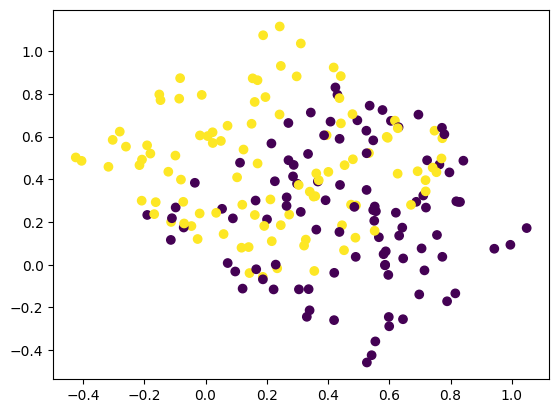

In [2]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=Y)

#使用 scatter 函数创建散点图。
#其中，X[:,0] 表示数据集中所有行的第一个特征，X[:,1] 表示数据集中所有行的第二个特征，
#c=Y 表示根据标签数组 Y 来指定散点的颜色

Now that we have generated our data $T_{n+m}:=\{(X_1,Y_1)$, $\ldots$, $(X_{n+m},Y_{n+m})\}$ which are sampled i.i.d., let us denote $Tr_n = \{(X_1,Y_1)$, $\ldots$, $(X_{n},Y_{n})\}$ the **training data** and $Te_m = \{(X_{n+1},Y_{n+1})$, $\ldots$, $(X_{n+m},Y_{n+m})\}$ the **testing data**.

In [3]:
n_plus_m = len(X)   #计算X中的总样本数量
n = n_plus_m//2     #训练集数量：样本数量的一半，并将结果赋值给变量n，用整除确保结果为整数
m = n_plus_m-n      #计算测试集的样本数量，即总数量-n
X_train = X[0:n,:]   #前n个点是训练集
Y_train = Y[0:n]     
X_test = X[n:n+m,:]   #后m个点是测试集。选取n~n+m-1行，以及所有列，构成测试集的特征矩阵
Y_test = Y[n:n+m]     #从标签数组Y中选择第n到n+m-1个标签，作为测试集的标签，赋值给Y_test

On the training data $Tr_n$ we will train the LM using some method (in this case the support vector machine from last time)

In [4]:
#这段代码使用cikit-learn 库中的支持向量机 (SVM) 中的 
#SVC 类（Support Vector Classification）来训练一个支持向量机模型

from sklearn.svm import SVC
# 从 scikit-learn 库中导入支持向量机的 SVC 类

svc = SVC(kernel='rbf')
#创建一个支持向量机模型的实例，使用径向基核（Radial Basis Function，'rbf'）作为核函数。
#SVM 中的核函数用于将数据映射到高维空间，以便更好地进行分类。

svc.fit(X_train,Y_train)
#用训练集 X_train 和对应的标签 Y_train 对支持向量机模型进行训练。
#这一步会调整模型参数，使其能够捕捉训练集中的模式

SVC()

This will find $g_{\hat \lambda}$, and store it inside the object `svc`.
To compute the empirical training risk for the $0-1$ loss 

$$
    \hat R_n(Tr_n; g_{\hat \lambda})
$$

we can do as follows, first let us compute $g_{\hat \lambda}(X_i)$ for $(X_i,Y_i) \in Tr_n$, we call this `prediction`

In [5]:
prediction = svc.predict(X_train)
#使用训练好的支持向量机模型 svc 对训练集 X_train 进行预测，
#得到预测结果并将其存储在变量 prediction 中

The empirical risk over the training data is just the average number of times the prediction deviates from the truth
#训练数据上的经验风险（empirical risk）就是预测结果与真实标签不一致的平均次数。这里“deviates from the truth”指的是预测结果与真实标签不一致，即模型犯错的情况。

In [13]:
np.mean(Y_train!=prediction)
'''计算了模型在训练数据上的经验风险,
Y_train != prediction：这是一个逐元素的比较操作，返回一个布尔数组，
表示每个样本的预测结果是否与真实标签不一致。

np.mean(...)：对布尔数组取平均值，
由于布尔值在计算时会被视为 1（True）或 0（False），
所以这一步计算了预测错误的样本占总样本的比例，即错误率。

因此，np.mean(Y_train != prediction) 给出了模型在训练数据上的错误率，即经验训练风险。'''

0.26

We now want to use our testing data to evaluate the performance, i.e. to estimate $R(\hat \lambda)$. This is simply done similarly

In [14]:
#这部分代码用训练好的支持向量机模型 svc 对测试集 X_test 进行预测，
#并计算了测试数据上的经验测试风险。

test_prediction = svc.predict(X_test)
#使用支持向量机模型对测试集进行预测，将结果存储在变量 test_prediction 中。

In [15]:
test_risk = np.mean(Y_test!=test_prediction)
#Y_test != test_prediction：逐元素比较，得到一个布尔数组，
#表示每个样本的预测结果是否与真实标签不一致。
#np.mean(...)：计算布尔数组的平均值，即错误率，表示测试数据上模型的错误率。

test_risk

#这段代码的目的是评估模型在测试数据上的性能，
#通过计算错误率来衡量模型对未见过的数据的泛化能力。

0.36

'''
这段文字解释了为什么训练集上的经验风险通常小于测试集上的经验风险，并介绍了如何使用霍夫丁不等式构建一个置信区间来估计真实风险'''

。From this we can see that clearly the empirical risk over the training set is much smaller than the empirical risk over the testing data. This is simply because we used the training data to fit our model, it is thus always smaller than the true risk. When using the new dataset to test our model we are formally working "conditioned" on the training data and thus the empirical test risk is just a sum of i.i.d. random variables, each taking value either 0 or 1. Hoeffdings inequality thus tells us that the test risk is close to the true risk

'''从中我们可以清楚地看到，训练集上的经验风险明显小于测试集上的经验风险。这是因为我们使用训练数据来拟合我们的模型，因此经验风险总是小于真实风险。当使用新数据集测试我们的模型时，我们形式上是在训练数据上进行“条件化”，因此经验测试风险只是一组独立同分布的随机变量之和，每个变量取值为0或1。 霍夫丁不等式告诉我们，测试风险接近于真实风险。

接着，提到了构建一个置信区间，使用了 Lemma 3.8 提供的信息。选择一个置信水平，计算真实风险的置信区间'''.

So, lets do that, i.e. let us build an interval of confidence around the true risk. Lemma 3.8 tells us that since the random variable $L(Y,g_{\hat \lambda}(X)) \sim $Bernoulli($R(\hat \lambda)$), we can choose our level of confidence, say $\alpha = 0.01$ and then compute $\delta = \frac{1}{\sqrt{m}}\sqrt{\frac{1}{2}\ln\left ( \frac{2}{\alpha} \right )}$

In [24]:
alpha = 0.1
delta = (1/np.sqrt(m))*np.sqrt((1/2)*np.log(2/alpha))
print("Confidence interval around the true risk is [%.2f,%.2f]" % (test_risk-delta,test_risk+delta))

#选择置信水平为0.1，即90%的置信水平
#使用hoeffding不等式计算delta，其中m是测试集的样本数量
#用了 % 操作符和字符串格式化，将置信区间的下限和上限插入到字符串中

Confidence interval around the true risk is [0.24,0.48]


## Other metrics

'''这段文字讨论了除了$0-1$损失外的其他度量标准，具体是$1-$准确率（在机器学习社区中使用的术语）以及精确率（Precision）和召回率（Recall）"

$1-$accuracy": 也就是$1-$准确率，是指模型在分类任务中被错误分类的样本占总样本数的比例。这是准确率的补数，即$1-$准确率表示分类错误的样本比例。

Precision（精确率）：在给定模型预测为正类别的情况下，实际为正类别的概率。其定义为$P(Y = 1 \mid g(X) = 1)$，表示在模型预测为正类别的情况下，实际为正类别的概率。

Recall（召回率）：在给定实际为正类别的情况下，模型预测为正类别的概率。其定义为$P(g(X) = 1 \mid Y = 1)$，表示在实际为正类别的情况下，模型成功预测为正类别 

这些指标对于评估模型在不同方面性能的情况下非常有用，尤其在处理不平衡数据集或强调对某一类别的重要性时。
的概率。'''

Sometimes it is important to compute other metrics than the $0-1$ loss. Actually this is $1-$accuracy (the term used in machine learning community).

The other classical quantities to look at is the so called **precision** and **recall**. Their definitions are as follows

$$
    \begin{aligned}
        \text{Precision:} \quad P(Y = 1 \mid g(X) = 1) \\
        \text{Recall:} \quad P(g(X) = 1 \mid Y = 1).
    \end{aligned}
$$

Lets start with Precision, it reads "What is the probability of $Y=1$ given that our decision function predicts $1$". Lets compute that for our trained model

In [27]:
# As we have mentioned before, conditional probabilities are easiest to compute by filtering
Y_test_g_1 = Y_test[test_prediction == 1]
#通过筛选，获取在模型预测为1的情况下实际为正类别的标签。

# The variable above then contains all the true labels given that our model predicts 1
print(Y_test_g_1)
print(len(Y_test_g_1))
#打印输出符合条件的样本数量，即在模型预测为1的情况下实际为正类别的样本数量。

[0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 1.]
75


To estimate the probability of $Y=1$ we can just take the mean of the above

In [18]:
precision = np.mean(Y_test_g_1)
#计算 Y_test_g_1 中元素的平均值，即在模型预测为1的情况下实际为正类别的标签的概率。
precision

0.56

So when the model predicts $1$, there is a $56\%$ of the true label being $1$. That is why its called precision!!

We can compute the interval of confidence for this one as well using Lemma 3.8

In [19]:
alpha = 0.01
delta = (1/np.sqrt(len(Y_test_g_1)))*np.sqrt((1/2)*np.log(2/alpha))
print("Confidence interval around precision [%.2f,%.2f]" % (precision-delta,precision+delta))

Confidence interval around precision [0.37,0.75]


The recall on the other hand reads "What is the probability of the model guessing $1$ given that the true label is $1$". (You should think about why its termed recall).

This we again do using filtering, but this time on $Y=1$:

In [20]:
# As we have mentioned before, conditional probabilities are easiest to compute by filtering
test_prediction_Y_1 = test_prediction[Y_test == 1]

# The variable above then contains all the true labels given that our model predicts 1
print(test_prediction_Y_1)
print(len(test_prediction_Y_1))

[1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
45


In [21]:
recall = np.mean(test_prediction_Y_1)
recall

0.9333333333333333

As we can see, the recall is high. So when the true label is $1$, the model is very likely to predict correcly. Again we can derive an interval of confidence using Lemma 3.8

In [22]:
alpha = 0.01
delta = (1/np.sqrt(len(test_prediction_Y_1)))*np.sqrt((1/2)*np.log(2/alpha))
print("Confidence interval around precision [%.2f,%.2f]" % (recall-delta,recall+delta))

Confidence interval around precision [0.69,1.18]


Of course the upper bound can be replaced by $1$.

> In the above we computed several intervals, and we should really use the union bound correction of the interval lenght that was derived in the Remark after Lemma 3.8. This is also known as **Bonferroni correction**.

### Using sklearn to compute the metrics

In [23]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.88      0.40      0.55        55
         1.0       0.56      0.93      0.70        45

    accuracy                           0.64       100
   macro avg       0.72      0.67      0.62       100
weighted avg       0.74      0.64      0.62       100



Above you can see that the `classification_report` of sklearn actually outputs some different averaged metrics, and you can see that there is a precision and recall for class $0$ as well. These are simply 

$$
    \begin{aligned}
        \text{Precision:} \quad P(Y = 0 \mid g(X) = 0) \\
        \text{Recall:} \quad P(g(X) = 0 \mid Y = 0).
    \end{aligned}
$$

### Implementing our own classification report with confidence

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def precision_recall(y_true,
    y_pred,
    labels=None,alpha=0.01, correction=1):
    p = []
    r = []
    f1 = []
    support = []
    for label in labels:
        y_true_pred_label = y_true[y_pred == label]
        precision = np.mean(y_true_pred_label == label)
        delta = (1/np.sqrt(len(y_true_pred_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
        p.append("%.2f : [%.2f,%.2f]" % (precision, np.maximum(precision-delta,0),np.minimum(precision+delta,1)))
        
        y_pred_true_label = y_pred[y_true == label]
        recall = np.mean(y_pred_true_label == label)
        delta = (1/np.sqrt(len(y_pred_true_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
        r.append("%.2f : [%.2f,%.2f]" % (recall, np.maximum(recall-delta,0),np.minimum(recall+delta,1)))
        
    return (p,r)

def accuracy_interval(y_true,y_pred,alpha=0.01,correction=1):
    acc = np.mean(y_true == y_pred)
    delta = (1/np.sqrt(len(y_true)))*np.sqrt((1/2)*np.log(2*correction/alpha))
    return "%.2f : [%.2f,%.2f]" % (acc, np.maximum(acc-delta,0),np.minimum(acc+delta,1))

def classification_report_interval(
    y_true,
    y_pred,
    labels=None,
    alpha = 0.01,
    union_bound_correction=True
):
    digits = 18
    target_names = None
    if labels is None:
        labels = list(set(y_true).union(set(y_pred)))
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall"]
    # compute per-class results without averaging
    # Simple correction using the union bound
    # We are computing 2 intervals for each label for precision and recall
    # In addition we are computing 2 intervals for accuracy
    # This is in total 2*n_labels+2
    if (union_bound_correction):
        correction = 2*len(labels)+2
    else:
        correction=1
    p, r = precision_recall(
        y_true,
        y_pred,
        labels=labels,
        alpha=alpha,
        correction=correction
    )

    rows = zip(target_names, p, r)

    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, digits)
    head_fmt = "{:>{width}s} " + " {:>{digits}}" * len(headers)
    report = head_fmt.format("labels", *headers, width=width,digits=digits)
    report += "\n\n"
    row_fmt = "{:>{width}s} " + " {:>{digits}s}" * 2 + "\n"
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    row_fmt_acc = "{:>{width}s} " + " {:>{digits}s}" * 2 + " {:>{digits}s}""\n"
    report += "\n"
    accuracy = accuracy_interval(y_true,y_pred,alpha=alpha,correction=correction)
    report+=row_fmt_acc.format(*("accuracy","","",accuracy),width=width,digits=digits)

    return report

In [ ]:
print(classification_report_interval(Y_test,test_prediction,alpha=0.01,union_bound_correction=True))

In [ ]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()

from sklearn.svm import SVC

labels = digits['target']

X = digits['data']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,labels)

per = SVC(kernel='linear')

per.fit(X_train,Y_train)

In [ ]:
print(classification_report_interval(Y_test,per.predict(X_test),union_bound_correction=True))

In [ ]:
print(classification_report_interval(Y_test,per.predict(X_test),union_bound_correction=False))

## Overfitting



In [ ]:
# Lets create a dataset with only noise
X = np.random.normal(size=(1000,2))
Y = np.random.randint(0,2,size=1000)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

In [ ]:
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train)

In [98]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,Y_train)

DecisionTreeClassifier()

In [99]:
DecisionTreeClassifier()

DecisionTreeClassifier()

Lets take a look at how the decision function looks like, we can do this by predicting on a bunch of random points.

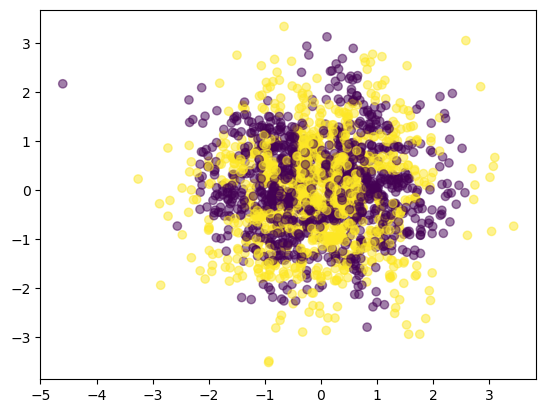

In [100]:
X_plot = np.random.normal(size=(2000,2))
prediction = dtc.predict(X_plot)
plt.scatter(X_plot[:,0],X_plot[:,1],c=prediction,alpha=0.5)

This means that it learned from noise and have learned completely irrelevant decisions. Lets check what the performance is on the data training data

In [101]:
print(classification_report(Y_train,dtc.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       1.00      1.00      1.00       254

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



So it correctly predicts all points, lets check the test metrics

In [97]:
print(classification_report_interval(Y_test,dtc.predict(X_test)))

            labels           precision             recall

                 0  0.55 : [0.43,0.67] 0.48 : [0.37,0.60]
                 1  0.50 : [0.39,0.62] 0.57 : [0.45,0.69]

          accuracy                                        0.52 : [0.44,0.61]



In [88]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,Y_train)

LogisticRegression()

In [89]:
print(classification_report(Y_train,lr.predict(X_train)))
print(classification_report_interval(Y_test,lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52       246
           1       0.55      0.58      0.56       254

    accuracy                           0.54       500
   macro avg       0.54      0.54      0.54       500
weighted avg       0.54      0.54      0.54       500

            labels           precision             recall

                 0  0.48 : [0.35,0.60] 0.42 : [0.30,0.54]
                 1  0.44 : [0.33,0.56] 0.50 : [0.38,0.62]

          accuracy                                        0.46 : [0.37,0.54]



In [ ]:
LogisticRegression()

These are quite different, we are now around 0.5. Which is what we expect, since the label was a coin flip with equal probability.

> Overfitting is thus the concept that we have fit "too well" to the training data and we have inflated our confidence.

Why is this happening?

## Overfitting and a posteriori vs a priori error

There are essentially two ways to make guarantees with machine learning, one is

* a priori (before the fact)
* a posteriori (after the fact).

What we saw above is the so called a posteriori version of guarantee. I.e. we are training and after the training (after the fact) we will test, to get the error. This is very applicable to many situations, as it does not guarantee anything about performance. If its bad, we are guaranteed that it is bad when testing, and if it is good, we are guaranteed it is good.

The other side of the coin is the a priori (before the fact) guarantee. These kinds of guarantees often come in the form of

> Given that we know how many data points we will get, can we say how good our learned model will be with respect to the best possible model in our class?

Remark: A consequence of this is also that the training and test error will be close, and they will both be close to the best possible.

> Given a model class $\mathcal{M}$ the a priori generalization statement can be written mathematicall as
$$
    P \left ( R(\hat{\phi}) > \inf_{\phi \in \mathcal{M}} R(\phi) + \epsilon \right ) \text{ is small.}
$$
Where $\hat \phi$ is the empirical risk minimizer.

### What reduces overfitting?

As we saw, overfitting learns random noise. Since random noise is very complicated (its random, it has little structure) the resulting model must thus be very complicated. **Look at the decision tree above**. But this is not the entire truth, actually it is like this

> "Overfitting" -> too complicated model

However, it is not the other way around. It is also a lot more complicated to explain all the things that goes into making a good model and what highly complicated models to not overfit in some circumstances and overfit in others.

However, there is a theory that allows us to make guarantees in certain restricted cases and it looks like this
$$
    P \left ( R(\hat{\phi}) > \inf_{\phi \in \mathcal{M}} R(\phi) + \epsilon \right ) \leq 8 \left ( \frac{n e}{k}\right )^k e^{-n\epsilon^2/64}.
$$
and $k$ here is a measure of complexity of the model space $\mathcal{M}$, termed the VC-dimension. We have the immediate conclusion

> Smaller VC-dimension -> better guarantee

### What is the VC-dimension of different models?

This is a very hard problem, even the concept VC dimension is itself conceptually difficult. What we can say though is that, the **Support Vector Machine with linear kernel** and **Logistic regression** both have VC-dimension equal to the dimension of the space $-1$.